In [1]:
# 設定超參數HyperParameters 
batch_size =  64 #128
epochs = 7
image_size = 128
lr=0.01

imageGen = True

## 一、載入相關套件

In [2]:
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils as np_utils
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation, Conv2DTranspose

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 18:22:09.386604+08:00


## 製作標籤&資料集

In [6]:
from imgGen import imgGenFunc

In [7]:
flip = 0; rotate = 0
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  5600
y_l:  5600


## 建立Model

In [8]:
model_resnet = ResNet152V2(weights='imagenet', include_top=False)

input = Input( shape=(image_size,image_size,3),name = 'image_input' )
output_conv = model_resnet(input)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
## 由於該問題是分 3 類，需要在最後修改 Dense(3)，softmax 代表 output 是機率  
#Add the fully-connected layers 
p = Flatten()(output_conv)
p = Dense(256,activation = 'relu')(p)
p = Dropout(0.2)(p)
p = Dense(3, activation='softmax', name='predictions')(p)

model = Model(inputs=input, outputs=p)

model_2 = Model(inputs=input, outputs=p)
model_3 = Model(inputs=input, outputs=p)
model_4 = Model(inputs=input, outputs=p)

In [10]:
adam = optimizers.Adam(lr=lr)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])


model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model_4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

## 訓練

In [11]:
# Model檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [12]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [13]:
### Start Training
history_1 = model.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 5040 samples, validate on 560 samples
Epoch 1/7
5040/5040 [==============================] - 141s 28ms/sample - loss: 0.9969 - acc: 0.6252 - val_loss: 852.8178 - val_acc: 0.3018
Epoch 2/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.9386 - acc: 0.6597 - val_loss: 8712.1261 - val_acc: 0.3518
Epoch 3/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.7369 - acc: 0.6750 - val_loss: 2.6055 - val_acc: 0.5036
Epoch 4/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.7637 - acc: 0.6762 - val_loss: 4006.2291 - val_acc: 0.3821
Epoch 5/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.6611 - acc: 0.7224 - val_loss: 0.9185 - val_acc: 0.6036
Epoch 6/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.6573 - acc: 0.7153 - val_loss: 2.5831 - val_acc: 0.5661
Epoch 7/7
5040/5040 [==============================] - 105s 21ms/sample - loss: 0.6089 - acc: 0.7333 - val_loss: 1.06

In [14]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 18:36:59.039381+08:00


(14, 49)

## 繪製Model學習成效

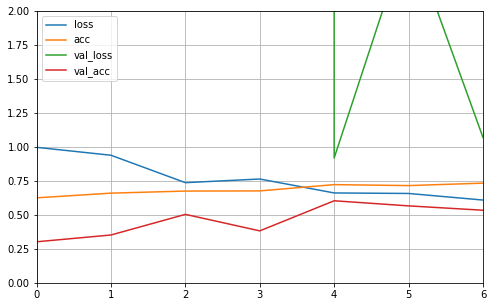

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
plot_learning_curves(history_1)

## 測試集預測準確度

In [16]:
csvfile_test = open('dev.csv')
reader_test = csv.reader(csvfile_test)

In [17]:
# 讀取csv標籤
labels = []
for line in reader_test:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)
csvfile_test.close() 

In [18]:
labels = labels[1:]  # remove the first row
print("芒果圖片數量: ",len(labels))

芒果圖片數量:  800


In [19]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("A","0")
    labels[i][1] = labels[i][1].replace("B","1")
    labels[i][1] = labels[i][1].replace("C","2")

In [20]:
x_test = []
y_test = []

for i in range(len(labels)):
    img = cv2.imread("C1-P1_Dev/" + labels[i][0] )
    res = cv2.resize(img,(image_size,image_size),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    x_test.append(res)    
    y_test.append(labels[i][1])

In [21]:
y_test_org = y_test

# 轉換至array的格式
x_test = np.array(x_test)
y_test = np.array(y_test)

In [22]:
# 轉換至float的格式
for i in range(len(x_test)):
    x_test[i] = x_test[i].astype('float32')
# x_test = x_test/255

In [23]:
# 標籤進行one-hotencoding
y_test = np_utils.to_categorical(y_test)

In [24]:
# 測試集標籤預測
y_pred = model.predict(x_test)

In [25]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 2 1 1 0 1 1 1 1 1 0 1 1 2 1 1 0 2
 1 1 1 1 0 1 2 1 2 1 2 1 0 0 0 0 1 1 2 1 1 0 0 1 2 1 2 1 1 1 1 1 1 1 0 2 1
 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 2 1 1 1 1 1 0 1 2 1 1 0 1 0 1 2 1 0 1 1 0 0
 2 1 2 1 0 1 1 1 2 1 1 0 1 1 2 1 1 1 0 1 1 2 0 1 1 1 1 1 0 2 2 1 1 1 1 1 0
 2 1 1 0 1 1 1 1 2 1 2 0 1 1 1 1 0 2 1 2 1 1 0 2 1 0 1 2 1 1 1 1 1 2 2 1 1
 1 1 2 2 2 0 1 1 1 1 0 1 2 1 1 1 1 2 1 2 1 2 1 0 1 0 1 2 1 1 1 0 1 2 1 0 2
 0 1 1 1 1 0 0 1 2 2 0 1 1 1 1 1 0 0 1 1 1 2 2 1 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 2 1 1 2 1 1 2 1 2 0 1 2 0 0 1 1 0 1 1 1 1 1 2 1 0 0 1 0 1 0 1 1 1 2 1 1
 1 1 1 1 0 2 1 0 1 2 1 1 0 1 1 2 1 0 1 0 0 2 2 1 0 2 0 1 1 1 1 1 1 2 0 1 0
 1 1 1 1 1 1 1 2 1 1 0 2 0 1 0 1 2 1 2 0 1 1 1 1 1 2 1 0 0 1 2 1 1 1 1 0 1
 1 1 1 2 1 1 1 1 1 1 1 2 0 1 1 1 2 1 1 1 1 2 1 1 1 0 1 1 2 2 0 0 0 1 1 1 1
 1 2 1 1 1 1 0 2 1 2 0 0 1 1 0 1 1 2 1 1 0 1 2 1 1 0 2 1 1 0 2 0 1 1 0 1 1
 1 0 1 0 0 1 1 0 1 1 1 2 0 1 1 0 0 1 1 2 0 2 1 1 0 1 1 2 2 1 1 1 1 1 1 2 1
 1 1 1 1 2 1 0 0 1 1 2 1 

In [26]:
# 模型原標籤
true_label = y_test_org
true_label = np.array(true_label)
print(true_label)
# print(len(true_label))

['1' '0' '1' '1' '2' '1' '2' '0' '1' '0' '0' '1' '2' '1' '2' '1' '1' '0'
 '0' '1' '0' '0' '2' '0' '1' '0' '2' '2' '1' '1' '1' '0' '2' '2' '0' '0'
 '0' '0' '0' '0' '1' '2' '0' '2' '2' '2' '1' '0' '2' '0' '1' '1' '1' '2'
 '2' '0' '1' '0' '2' '0' '1' '1' '2' '0' '1' '2' '2' '0' '2' '1' '2' '1'
 '1' '2' '2' '2' '1' '0' '2' '0' '0' '2' '1' '1' '2' '2' '2' '2' '0' '1'
 '2' '2' '1' '2' '2' '2' '1' '0' '2' '2' '2' '1' '1' '2' '1' '1' '1' '1'
 '1' '2' '2' '0' '1' '0' '0' '2' '2' '0' '2' '0' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '1' '0' '0' '0' '1' '0' '2' '1' '1' '0' '2' '0' '1' '2' '0'
 '0' '0' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '0' '2' '1' '2' '1'
 '0' '1' '2' '2' '1' '2' '0' '2' '1' '2' '2' '2' '2' '1' '0' '0' '0' '1'
 '2' '2' '0' '2' '1' '2' '0' '0' '2' '1' '2' '2' '1' '1' '2' '1' '0' '2'
 '1' '0' '2' '2' '1' '0' '1' '2' '0' '1' '2' '2' '2' '1' '1' '2' '0' '2'
 '1' '2' '1' '1' '0' '1' '1' '1' '1' '1' '0' '0' '1' '1' '0' '2' '1' '1'
 '0' '1' '2' '0' '2' '0' '1' '2' '2' '0' '1' '0' '2

In [27]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,45,149,49
1,57,183,53
2,59,158,47


In [28]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:34.38%


In [29]:
# 儲存模型相關參數
# model.save('h5/'+file_name+'.h5')

## Test 2

In [30]:
flip = 0; rotate = 1
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  16800
y_l:  16800


In [31]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 18:38:30.018696+08:00


In [32]:
### Start Training
history_2 = model_2.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 15120 samples, validate on 1680 samples
Epoch 1/7
15120/15120 [==============================] - 347s 23ms/sample - loss: 0.7227 - acc: 0.6915 - val_loss: 11.6263 - val_acc: 0.5607
Epoch 2/7
15120/15120 [==============================] - 315s 21ms/sample - loss: 0.7484 - acc: 0.6759 - val_loss: 1.6127 - val_acc: 0.6315
Epoch 3/7
15120/15120 [==============================] - 315s 21ms/sample - loss: 0.6514 - acc: 0.7151 - val_loss: 11.6354 - val_acc: 0.4185
Epoch 4/7
15120/15120 [==============================] - 315s 21ms/sample - loss: 0.6095 - acc: 0.7329 - val_loss: 0.7325 - val_acc: 0.6946
Epoch 5/7
15120/15120 [==============================] - 315s 21ms/sample - loss: 0.6048 - acc: 0.7372 - val_loss: 0.6660 - val_acc: 0.7363
Epoch 6/7
15120/15120 [==============================] - 314s 21ms/sample - loss: 0.5404 - acc: 0.7585 - val_loss: 0.7774 - val_acc: 0.7024
Epoch 7/7
15120/15120 [==============================] - 315s 21ms/sample - loss: 0.5199 - acc: 0.7677 - val_

In [33]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 19:16:09.257851+08:00


(37, 39)

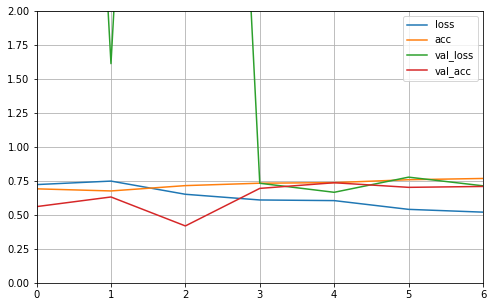

In [34]:
plot_learning_curves(history_2)

In [35]:
# 測試集標籤預測
y_pred = model_2.predict(x_test)

In [36]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [37]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,0,243,0
1,1,290,2
2,0,264,0


In [38]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:36.25%


## Test 3

In [39]:
flip = 1; rotate = 0
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  22400
y_l:  22400


In [40]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 19:17:32.306679+08:00


In [41]:
### Start Training
history_3 = model_3.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 20160 samples, validate on 2240 samples
Epoch 1/7
20160/20160 [==============================] - 455s 23ms/sample - loss: 0.5557 - acc: 0.7579 - val_loss: 2.7903 - val_acc: 0.5478
Epoch 2/7
20160/20160 [==============================] - 422s 21ms/sample - loss: 0.5114 - acc: 0.7741 - val_loss: 0.7569 - val_acc: 0.6897
Epoch 3/7
20160/20160 [==============================] - 422s 21ms/sample - loss: 0.4961 - acc: 0.7789 - val_loss: 0.5956 - val_acc: 0.7496
Epoch 4/7
20160/20160 [==============================] - 422s 21ms/sample - loss: 0.4558 - acc: 0.7979 - val_loss: 0.7358 - val_acc: 0.7188
Epoch 5/7
20160/20160 [==============================] - 421s 21ms/sample - loss: 0.7026 - acc: 0.7190 - val_loss: 2.3169 - val_acc: 0.6580
Epoch 6/7
20160/20160 [==============================] - 421s 21ms/sample - loss: 0.5859 - acc: 0.7383 - val_loss: 0.6308 - val_acc: 0.7321
Epoch 7/7
20160/20160 [==============================] - 421s 21ms/sample - loss: 0.5029 - acc: 0.7755 - val_lo

In [42]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 20:07:44.451280+08:00


(50, 12)

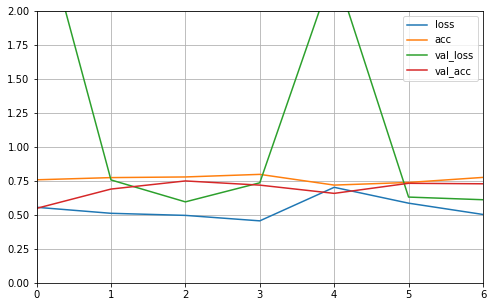

In [43]:
plot_learning_curves(history_3)

In [44]:
# 測試集標籤預測
y_pred = model_3.predict(x_test)

In [45]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[2 2 1 2 2 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 2 1 2 0 1
 1 1 1 2 2 1 2 1 1 2 2 2 1 2 0 1 1 2 2 2 1 1 1 2 1 2 1 2 1 1 2 2 1 2 1 1 1
 1 1 2 2 1 2 2 2 1 1 2 2 2 1 1 2 2 2 2 1 2 1 1 1 2 1 1 2 2 2 1 2 1 1 2 2 1
 1 2 1 2 2 1 2 1 2 2 1 1 2 2 2 1 1 1 2 1 1 2 1 2 1 2 2 1 2 1 1 1 2 1 1 1 2
 1 1 1 1 1 2 1 2 2 1 2 2 2 2 1 2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 1 1 2 1 2 1 2
 1 1 2 1 1 2 2 2 2 2 2 1 2 2 1 2 1 2 2 1 1 1 2 2 1 1 1 1 1 2 2 2 2 1 2 1 1
 1 2 2 2 2 2 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 2 1 1 1 2
 1 1 2 2 1 2 2 2 2 2 1 2 2 2 1 1 1 2 2 2 1 1 1 1 1 2 1 2 2 1 1 1 2 2 2 1 2
 1 2 1 1 2 1 1 1 2 2 2 1 2 1 2 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 1 1 1 2 1 2 2
 1 1 2 2 2 2 2 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 2 1 1 1 1 2 2 2 2 1 1 2 2 1 1 2 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 1 2 2
 1 2 1 2 2 1 1 1 2 2 2 2 1 2 1 2 1 1 1 2 2 2 1 1 1 1 2 2 2 2 1 2 2 1 2 1 1
 1 1 1 1 1 2 2 2 2 1 1 1 1 2 1 2 1 2 1 1 1 2 2 2 1 1 1 2 2 2 0 2 1 1 1 1 1
 2 1 1 1 1 1 1 2 1 1 2 1 

In [46]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,5,163,75
1,1,158,134
2,0,125,139


In [47]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:37.75%


## Test 4

In [48]:
flip = 1; rotate = 1
x_train, y_train = imgGenFunc(image_size, flip, rotate)

芒果圖片數量:  5600
x_l:  33600
y_l:  33600


In [49]:
# Print Start time
from datetime import datetime, timezone
import pytz

tpe = pytz.timezone('Asia/Taipei')
utc_start = datetime.now()
print("Start Time", tpe.fromutc(utc_start))

Start Time 2020-05-28 20:09:15.345326+08:00


In [50]:
### Start Training
history_4 = model_4.fit(
    x = x_train, 
    y = y_train, 
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_split=0.1
)

Train on 30240 samples, validate on 3360 samples
Epoch 1/7
30240/30240 [==============================] - 668s 22ms/sample - loss: 0.5188 - acc: 0.7706 - val_loss: 0.6939 - val_acc: 0.7196
Epoch 2/7
30240/30240 [==============================] - 632s 21ms/sample - loss: 0.4700 - acc: 0.7945 - val_loss: 0.5104 - val_acc: 0.7818
Epoch 3/7
30240/30240 [==============================] - 632s 21ms/sample - loss: 0.4318 - acc: 0.8106 - val_loss: 0.7071 - val_acc: 0.6792
Epoch 4/7
30240/30240 [==============================] - 632s 21ms/sample - loss: 0.4779 - acc: 0.8019 - val_loss: 0.8347 - val_acc: 0.7000
Epoch 5/7
30240/30240 [==============================] - 632s 21ms/sample - loss: 0.4553 - acc: 0.8021 - val_loss: 0.6234 - val_acc: 0.7598
Epoch 6/7
30240/30240 [==============================] - 633s 21ms/sample - loss: 0.3667 - acc: 0.8423 - val_loss: 0.8451 - val_acc: 0.6744
Epoch 7/7
30240/30240 [==============================] - 633s 21ms/sample - loss: 0.3122 - acc: 0.8673 - val_lo

In [51]:
# Print Finish Training time
tpe = pytz.timezone('Asia/Taipei')
utc_finish = datetime.now()
print("Finish Training Time", tpe.fromutc(utc_finish))

difference = utc_finish-utc_start
seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

Finish Training Time 2020-05-28 21:24:07.044799+08:00


(74, 51)

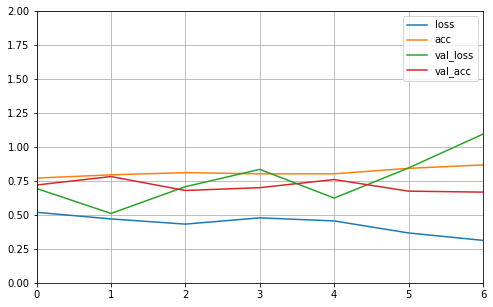

In [52]:
plot_learning_curves(history_4)

In [53]:
# 測試集標籤預測
y_pred = model_4.predict(x_test)

In [54]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
# print(len(predict_label))

[2 1 2 2 2 2 1 1 1 1 1 2 2 1 1 1 2 2 1 1 1 2 1 0 1 1 1 1 0 1 1 2 2 1 0 1 0
 0 1 2 2 2 1 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1
 1 2 0 1 1 2 1 2 1 2 1 1 2 1 1 2 1 2 1 2 1 1 1 0 1 1 2 2 1 1 1 2 2 1 1 2 1
 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 1 0 2 1 0 1 1 1 2
 1 1 1 1 1 1 1 1 2 0 2 2 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2
 1 0 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 2 0 1 1 2 2 1 1 1 1 0 1 1 2 1 1 1 1 0
 1 1 1 2 1 1 2 1 1 0 1 1 2 2 2 0 0 1 1 1 1 0 1 1 1 1 2 2 2 2 1 2 1 2 1 2 1
 1 2 1 1 1 1 1 2 1 1 2 1 2 1 1 2 2 2 2 1 0 1 1 1 0 2 2 2 1 1 2 1 2 1 1 1 0
 0 2 1 0 2 1 1 0 2 1 1 1 2 2 1 1 2 2 1 0 0 1 2 0 2 1 1 1 1 1 1 1 0 1 1 1 2
 1 1 1 2 2 2 2 1 2 1 1 2 1 2 1 0 2 1 2 1 1 2 1 1 1 1 2 2 1 2 0 0 1 1 1 1 1
 1 2 1 2 1 2 2 1 2 2 0 1 1 1 1 1 1 2 2 2 1 1 0 1 1 1 2 1 2 1 0 0 1 0 2 1 2
 1 1 1 2 1 1 2 2 2 1 2 1 1 1 2 1 1 1 1 2 1 2 1 1 2 2 0 1 2 2 1 1 2 1 2 1 0
 0 0 1 1 0 1 1 1 2 0 0 0 2 2 1 1 2 1 1 1 1 1 2 0 1 2 1 2 1 1 2 1 1 1 0 2 1
 1 2 0 1 2 1 1 2 1 1 1 1 

In [55]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,47,125,71
1,15,193,85
2,13,173,78


In [56]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:39.75%
